In [128]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib
import matplotlib
import scipy.stats
from sklearn import cluster

In [10]:
def load_ces(file):
    df_ces = pd.read_table(file)
    ces = df_ces.sum()[2:]
    return pd.DataFrame(ces,columns=['ces'])

def load_data(file, cat=None):    
    df = pd.read_table(file)
    patients = df['COMMON']
    df = df.transpose()[2:]
    if cat:
        df.columns = [s + '_' +cat for s in patients]
    else: 
        df.columns = patients
    return df

def load_mutation(file):
    df = pd.read_table(file)[['Sample ID', 'Mutation Count', 'CNA']]
    return df

In [89]:
df1 = load_ces('data/colorectal/cBioPortal_data.txt')
df2 = load_mutation('data/colorectal/Mutation Count vs. CNA.txt')
df3 = load_data('data/colorectal/colorectal_msi_expr.txt')
df4 = load_data('data/colorectal/mmr_expr.txt', cat='expr')
df5 = load_data('data/colorectal/mmr_mut.txt', cat='mut')
df = df1.merge(df2,right_on='Sample ID', left_index=True)
df = df.merge(df3, left_on='Sample ID', right_index=True)
df = df.merge(df4, left_on='Sample ID', right_index=True)
df = df.merge(df5,how='outer', left_on='Sample ID', right_index=True)
df.index = df['Sample ID']
df.head()

,ces,Sample ID,Mutation Count,CNA,AHR,AMFR,ANG,ATP5A1,CALM1,CASP2,...,PMS2_expr,RFC1_expr,MLH1_mut,MLH3_mut,MSH2_mut,MSH3_mut,MSH6_mut,PCNA_mut,PMS2_mut,RFC1_mut
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-D5-6531-01,1.8834,TCGA-D5-6531-01,NaN,0.645299,-0.2984,-0.6495,-0.8204,0.9265,-1.7234,2.875,...,1.62,-0.4752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-DM-A28A-01,6.4499,TCGA-DM-A28A-01,NaN,0.269859,-1.0773,-0.5238,-0.5854,-2.0746,-0.7818,0.0617,...,1.7332,-0.459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-DC-5869-01,7.8741,TCGA-DC-5869-01,NaN,0.408536,0.375,-0.186,-0.6932,-1.7211,-1.31,-0.8216,...,1.3353,-0.7944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-F4-6460-01,-4.8967,TCGA-F4-6460-01,NaN,0.594362,-0.326,0.6383,-0.3655,-2.3986,-0.5795,1.736,...,1.8744,-1.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-DY-A1DC-01,1.8764,TCGA-DY-A1DC-01,NaN,0.274076,-0.4386,0.765,-0.4288,-1.8909,0.1764,0.2216,...,0.9144,-0.6215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Colorectal specific detection (the "true" method)

In [73]:
upreg = ['ANG','TFF2','SRSF6','SET','EIF5A','RARRES1' ,'CRIP1','CD55','IQGAP2','P4HA1',
         'TYMS','GLRX','NUCB2','FUT8','HNRNPL','PCCB','EIF5A','POLR2L','GTF2A2','GALNT1',
         'NDUFA9','TNNT1','AHR','PRKAR2B','ATP5A1','AMFR','OSTF1','CALM1','MANF','EWSR1',
         'SSR1','MFAP1','GNAQ','PPP2R5E','USP14','GCH1','KIF11','CASP2','SLC1A1','PGGT1B','RAB27B']
downreg = ['FTO','PLAGL1','STK38','DMD','NONO','CSNK1E','TCF7','POFUT1','OCRL','ELF1','LRP1','MLH1',
           'MARCKS','JUN','ELN','RAB32','TSC22D1','YWHAB','SEMA3C','GABRE','NEK3','PRKCI','TGFBR2',
           'FCGRT','CFTR','SERINC3','HSPH1','TDGF1','CYP2B7P']
mmr_path = ['MLH1','MSH6', 'PMS2', 'MSH2','MSH3', 'MLH3', 'RFC1', 'PCNA']

In [92]:
def mmr_classifier1(df):
    df['cat1'] = np.zeros(len(df))
    for ix in df.index:
        up = df[upreg].loc[ix].sum()
        down = df[downreg].loc[ix].sum()  
        if up > 0 and down < 0:
            # MSI tumor
            df.loc[ix, 'cat1'] = 1
        elif up < 0 and down > 0:
            # MSS tumor
            df.loc[ix, 'cat1'] = 0
        else:
            # Unkown tumor type
            df.loc[ix, 'cat1'] = 0.5
    return df

In [93]:
df = mmr_classifier1(df)
df.head()

,ces,Sample ID,Mutation Count,CNA,AHR,AMFR,ANG,ATP5A1,CALM1,CASP2,...,RFC1_expr,MLH1_mut,MLH3_mut,MSH2_mut,MSH3_mut,MSH6_mut,PCNA_mut,PMS2_mut,RFC1_mut,cat1
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-D5-6531-01,1.8834,TCGA-D5-6531-01,NaN,0.645299,-0.2984,-0.6495,-0.8204,0.9265,-1.7234,2.875,...,-0.4752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
TCGA-DM-A28A-01,6.4499,TCGA-DM-A28A-01,NaN,0.269859,-1.0773,-0.5238,-0.5854,-2.0746,-0.7818,0.0617,...,-0.459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
TCGA-DC-5869-01,7.8741,TCGA-DC-5869-01,NaN,0.408536,0.375,-0.186,-0.6932,-1.7211,-1.31,-0.8216,...,-0.7944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
TCGA-F4-6460-01,-4.8967,TCGA-F4-6460-01,NaN,0.594362,-0.326,0.6383,-0.3655,-2.3986,-0.5795,1.736,...,-1.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
TCGA-DY-A1DC-01,1.8764,TCGA-DY-A1DC-01,NaN,0.274076,-0.4386,0.765,-0.4288,-1.8909,0.1764,0.2216,...,-0.6215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


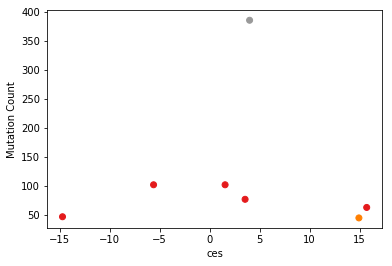

In [94]:
plt.scatter(df['ces'],df['Mutation Count'],c=df['cat1'],cmap=plt.cm.Set1,marker='o')
plt.xlabel('ces')
plt.ylabel('Mutation Count')
plt.show()

# General MSI detection (the tested one)

In [115]:
def classifier_expr(df, genes, thresh=0.05, double_detection=None):
    df['cat2'] = np.zeros(len(df))
    for g in genes:
        limit = df[g+'_expr'].quantile(thresh)
        if double_detection:
            limit2 = df[g+'_expr'].quantile(double_detection)
            
        for ix in df[df[g+'_expr']<limit].index:
            df.loc[ix, 'cat2'] = 1
            
        if double_detection:
            for ix in df[df[g+'_expr']<limit2].index:
                df.loc[ix, 'cat2'] += 0.5
    return df
                
def classifier_mut(df, genes):
    for g in genes:
        no_mutations = pd.isnull(df[g+'_mut'])
        for ix in no_mutations[no_mutations==False].index:
            df.loc[ix, 'cat2'] = 1
    return df
            
def classifier2(df, genes, thresh=0.05, double_detection=None):
    df = classifier_expr(df, genes, thresh, double_detection)
    df = classifier_mut(df, genes)
    return df

In [120]:
df = classifier2(df, mmr_path, thresh=0.1)
df

,ces,Sample ID,Mutation Count,CNA,AHR,AMFR,ANG,ATP5A1,CALM1,CASP2,...,MLH3_mut,MSH2_mut,MSH3_mut,MSH6_mut,PCNA_mut,PMS2_mut,RFC1_mut,cat1,cat2,benchmark
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-D5-6531-01,1.8834,TCGA-D5-6531-01,NaN,0.645299,-0.2984,-0.6495,-0.8204,0.9265,-1.7234,2.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,TN
TCGA-DM-A28A-01,6.4499,TCGA-DM-A28A-01,NaN,0.269859,-1.0773,-0.5238,-0.5854,-2.0746,-0.7818,0.0617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,TN
TCGA-DC-5869-01,7.8741,TCGA-DC-5869-01,NaN,0.408536,0.375,-0.186,-0.6932,-1.7211,-1.31,-0.8216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,TN
TCGA-F4-6460-01,-4.8967,TCGA-F4-6460-01,NaN,0.594362,-0.326,0.6383,-0.3655,-2.3986,-0.5795,1.736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,TN
TCGA-DY-A1DC-01,1.8764,TCGA-DY-A1DC-01,NaN,0.274076,-0.4386,0.765,-0.4288,-1.8909,0.1764,0.2216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,TN
TCGA-CM-5862-01,0.2606,TCGA-CM-5862-01,NaN,0.676374,0.122,0.7976,-0.6588,-1.9642,-0.6586,-0.9594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,TN
TCGA-CK-4947-01,-5.2833,TCGA-CK-4947-01,NaN,0.066471,-0.3814,-0.6584,-0.2356,0.0254,0.1324,-0.7409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.0,0
TCGA-AH-6544-01,15.3491,TCGA-AH-6544-01,NaN,0.418688,-0.1834,0.6131,-0.2301,-2.1067,-0.0313,1.5195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,TN
TCGA-G4-6302-01,-19.3075,TCGA-G4-6302-01,NaN,0.000004,-0.0074,0.6331,-0.3781,-0.8285,1.1377,-0.8767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,FP


In [121]:
df['benchmark'] = np.zeros(len(df))
for ix,row in df.iterrows():
    if row['cat1'] == 0:
        if row['cat2'] == 0:
            df.loc[ix,'benchmark'] = 'TN'
        elif row['cat2'] == 1:
            df.loc[ix, 'benchmark'] = 'FP'
            
    elif row['cat1'] == 1:
        if row['cat2'] == 0:
            df.loc[ix,'benchmark'] = 'FN'
        elif row['cat2'] == 1:
            df.loc[ix, 'benchmark'] = 'TP'

In [122]:
bench = df['benchmark'].value_counts()
print(str(len(df)-bench[0]) + ' tumors classified by both algorithm')
print('Recall = '+str(bench['TP']/(bench['TP']+bench['FN'])))
print('Precision = '+str(bench['TP']/(bench['TP']+bench['FP'])))

340 tumors classified by both algorithm
Recall = 0.8
Precision = 0.300578034682
